In [1]:
# Import libraries and modules
import sys
import tensorflow as tf
import numpy as np
import shutil
print(tf.__version__)
print(np.__version__)
np.set_printoptions(threshold = np.inf)

1.13.1
1.16.2


In [2]:
# !pip install tensorflow==1.12.0

In [3]:
# tf.enable_eager_execution()
tf.executing_eagerly()

False

In [4]:
# import os
# BUCKET = 'qwiklabs-gcp-8923d4964bfbd247-bucket' # REPLACE WITH A BUCKET NAME (PUT YOUR PROJECT ID AND WE CREATE THE BUCKET ITSELF NEXT)
# PROJECT = 'qwiklabs-gcp-8923d4964bfbd247' # REPLACE WITH YOUR PROJECT ID
# REGION = 'us-central1' # REPLACE WITH YOUR REGION e.g. us-central1

# # Import os environment variables
# os.environ['PROJECT'] = PROJECT
# os.environ['BUCKET'] =  BUCKET
# os.environ['REGION'] = REGION
# os.environ['TFVERSION'] = '1.8'

# Create data

## Create data generator

In [4]:
percent_sequence_before_anomaly = 80.0
percent_sequence_after_anomaly = 0.0

def create_time_series_normal_parameters():
    normal_frequency_noise_scale = 0.1
    normal_frequence_noise_shift = 0.0

    normal_amplitude_noise_scale = 1.0
    normal_amplitude_noise_shift = 1.0

    normal_noise_noise_scale = 0.2

    normal_freq = (np.random.random() * normal_frequency_noise_scale) + normal_frequence_noise_shift
    normal_ampl = np.random.random() * normal_amplitude_noise_scale + normal_amplitude_noise_shift

    return {"normal_freq": normal_freq, "normal_ampl": normal_ampl, "normal_noise_noise_scale": normal_noise_noise_scale}
  

def create_time_series_normal(number_of_sequences, sequence_length, normal_freq, normal_ampl, normal_noise_noise_scale):
    # Normal parameters
    normal_noise = [np.random.random() * normal_noise_noise_scale for i in range(0, number_of_sequences * sequence_length)]

    sequence = np.sin(np.arange(0, number_of_sequences * sequence_length) * normal_freq) * normal_ampl + normal_noise

    sequence = sequence.reshape(number_of_sequences, sequence_length)

    return sequence

def create_time_series_with_anomaly(number_of_sequences, sequence_length, percent_sequence_before_anomaly, percent_sequence_after_anomaly, normal_freq, normal_ampl, normal_noise_noise_scale):
    sequence_length_before_anomaly = int(sequence_length * percent_sequence_before_anomaly / 100.0)
    sequence_length_after_anomaly = int(sequence_length * percent_sequence_after_anomaly / 100.0)
    sequence_length_anomaly = sequence_length - sequence_length_before_anomaly - sequence_length_after_anomaly

    # normal parameters
    normal_noise_before = [np.random.random() * normal_noise_noise_scale for i in range(0, number_of_sequences * sequence_length_before_anomaly)]
    normal_noise_after = [np.random.random() * normal_noise_noise_scale for i in range(0, number_of_sequences * sequence_length_after_anomaly)]

    # Anomalous parameters
    anomalous_frequency_noise_scale = 2.0
    anomalous_frequence_noise_shift = 1.0

    anomalous_amplitude_noise_scale = 1.0
    anomalous_amplitude_noise_shift = 1.0

    anomalous_noise_noise_scale = 1.0

    anomalous_freq = (np.random.random() * anomalous_frequency_noise_scale) + anomalous_frequence_noise_shift
    anomalous_ampl = np.random.random() * anomalous_amplitude_noise_scale + anomalous_amplitude_noise_shift
    anomalous_noise = [np.random.random() * anomalous_noise_noise_scale for i in range(0, number_of_sequences * sequence_length_anomaly)]

    sequence_before_anomaly = np.sin(np.arange(0, number_of_sequences * sequence_length_before_anomaly) * normal_freq) * normal_ampl + normal_noise_before
    sequence_before_anomaly = sequence_before_anomaly.reshape(number_of_sequences, sequence_length_before_anomaly)

    sequence_anomaly = np.sin(np.arange(0, number_of_sequences * sequence_length_anomaly) * anomalous_freq) * anomalous_ampl + anomalous_noise
    sequence_anomaly = sequence_anomaly.reshape(number_of_sequences, sequence_length_anomaly)

    sequence_after_anomaly = np.sin(np.arange(0, number_of_sequences * sequence_length_after_anomaly) * normal_freq) * normal_ampl + normal_noise_after
    sequence_after_anomaly = sequence_after_anomaly.reshape(number_of_sequences, sequence_length_after_anomaly)

    return np.concatenate(seq = [sequence_before_anomaly, sequence_anomaly, sequence_after_anomaly], axis = 1)

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


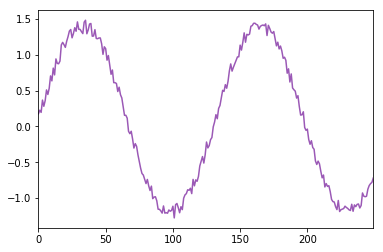

In [5]:
import seaborn as sns

test_normal_parameters = create_time_series_normal_parameters()

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 1):
    sns.tsplot(create_time_series_normal(5, 50, test_normal_parameters["normal_freq"], test_normal_parameters["normal_ampl"], test_normal_parameters["normal_noise_noise_scale"]).reshape(-1), color=flatui[i%len(flatui)] )

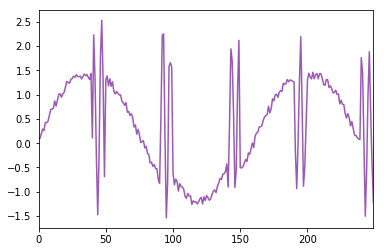

In [6]:
import seaborn as sns
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 1):
    sns.tsplot(create_time_series_with_anomaly(5, 50, percent_sequence_before_anomaly, percent_sequence_after_anomaly, test_normal_parameters["normal_freq"], test_normal_parameters["normal_ampl"], test_normal_parameters["normal_noise_noise_scale"]).reshape(-1), color=flatui[i%len(flatui)] )

## Create training and evaluation data

In [7]:
number_of_training_normal_sequences = 7000

number_of_validation_normal_1_sequences = 500
number_of_validation_normal_2_sequences = 500
number_of_validation_anomalous_sequences = 500

number_of_test_normal_sequences = 750
number_of_test_anomalous_sequences = 750

sequence_length = 30
number_of_tags = 3
tag_columns = ["tag_{0}".format(tag) for tag in range(0, number_of_tags)]

In [8]:
tag_data_list = [create_time_series_normal_parameters() for tag in range(0, number_of_tags)]
tag_data_list

[{'normal_ampl': 1.6841108247310859,
  'normal_freq': 0.08989812299598696,
  'normal_noise_noise_scale': 0.2},
 {'normal_ampl': 1.392386034441465,
  'normal_freq': 0.0835672880826654,
  'normal_noise_noise_scale': 0.2},
 {'normal_ampl': 1.7139322369965313,
  'normal_freq': 0.04302254868655767,
  'normal_noise_noise_scale': 0.2}]

In [9]:
training_normal_sequences_list = [create_time_series_normal(number_of_training_normal_sequences, sequence_length, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
training_normal_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = training_normal_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_training_normal_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
np.random.shuffle(training_normal_sequences_array)
print("training_normal_sequences_array.shape = \n{}".format(training_normal_sequences_array.shape))

training_normal_sequences_array.shape = 
(7000, 3)


In [10]:
validation_normal_1_sequences_list = [create_time_series_normal(number_of_validation_normal_1_sequences, sequence_length, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
validation_normal_1_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = validation_normal_1_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_validation_normal_1_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("validation_normal_1_sequences_array.shape = \n{}".format(validation_normal_1_sequences_array.shape))

validation_normal_2_sequences_list = [create_time_series_normal(number_of_validation_normal_2_sequences, sequence_length, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
validation_normal_2_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = validation_normal_2_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_validation_normal_2_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("validation_normal_2_sequences_array.shape = \n{}".format(validation_normal_2_sequences_array.shape))

validation_anomalous_sequences_list = [create_time_series_with_anomaly(number_of_validation_anomalous_sequences, sequence_length, percent_sequence_before_anomaly, percent_sequence_after_anomaly, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
validation_anomalous_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = validation_anomalous_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_validation_anomalous_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("validation_anomalous_sequences_array.shape = \n{}".format(validation_anomalous_sequences_array.shape))

validation_normal_1_sequences_array.shape = 
(500, 3)
validation_normal_2_sequences_array.shape = 
(500, 3)
validation_anomalous_sequences_array.shape = 
(500, 3)


In [11]:
test_normal_sequences_list = [create_time_series_normal(number_of_test_normal_sequences, sequence_length, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
test_normal_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = test_normal_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_test_normal_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("test_normal_sequences_array.shape = \n{}".format(test_normal_sequences_array.shape))

test_anomalous_sequences_list = [create_time_series_with_anomaly(number_of_test_anomalous_sequences, sequence_length, percent_sequence_before_anomaly, percent_sequence_after_anomaly, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
test_anomalous_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = test_anomalous_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_test_anomalous_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("test_anomalous_sequences_array.shape = \n{}".format(test_anomalous_sequences_array.shape))

test_normal_sequences_array.shape = 
(750, 3)
test_anomalous_sequences_array.shape = 
(750, 3)


In [12]:
np.savetxt(fname = "data/training_normal_sequences.csv", X = training_normal_sequences_array, fmt = '%s', delimiter = ";")

np.savetxt(fname = "data/validation_normal_1_sequences.csv", X = validation_normal_1_sequences_array, fmt = '%s', delimiter = ";")
np.savetxt(fname = "data/validation_normal_2_sequences.csv", X = validation_normal_2_sequences_array, fmt = '%s', delimiter = ";")
np.savetxt(fname = "data/validation_anomalous_sequences.csv", X = validation_anomalous_sequences_array, fmt = '%s', delimiter = ";")

np.savetxt(fname = "data/test_normal_sequences.csv", X = test_normal_sequences_array, fmt = '%s', delimiter = ";")
np.savetxt(fname = "data/test_anomalous_sequences.csv", X = test_anomalous_sequences_array, fmt = '%s', delimiter = ";")

In [13]:
!head -1 data/training_normal_sequences.csv

1.17588209,1.05248997,0.93330248,0.79585779,0.7711927,0.64252314,0.36529185,0.31966415,0.12049,-0.02315838,-0.18408219,-0.34160167,-0.43443768,-0.59391723,-0.71859844,-0.90603057,-1.04229937,-1.17005102,-1.17986309,-1.26120316,-1.27902823,-1.34428808,-1.46130118,-1.44180555,-1.48290365,-1.62330873,-1.53447242,-1.4965669,-1.45858258,-1.44984319;1.10150036,1.06313744,1.25884615,1.30087775,1.38168733,1.30737667,1.35017569,1.46623021,1.49516453,1.51426792,1.57407614,1.39059597,1.42930138,1.47367729,1.47282596,1.37248325,1.33060112,1.28984858,1.11574097,1.20980608,1.03024745,0.896286,0.83327662,0.77688691,0.66021202,0.62147174,0.51847441,0.40077178,0.27729859,0.0695406;-0.48617041,-0.43517075,-0.48325102,-0.30316557,-0.20990735,-0.12772672,-0.04023885,-0.10826945,0.05447991,0.19084117,0.20829731,0.18911231,0.35013336,0.41824704,0.48543645,0.52950674,0.63418491,0.59581893,0.7812336,0.80467754,0.95337157,0.96570593,0.91906614,1.02271859,1.04774539,1.13208155,1.26233606,1.344035,1.44741418,1.4

In [14]:
!head -1 data/validation_normal_1_sequences.csv

0.12861963,0.28185067,0.49474604,0.64731049,0.74643923,0.83694066,1.01080476,1.05947312,1.20598307,1.37761282,1.4006927,1.55876243,1.65470912,1.6990295,1.75363735,1.80409902,1.83416227,1.71197225,1.73024748,1.73211412,1.73893008,1.60906211,1.59873998,1.49971807,1.43998745,1.43692217,1.24297187,1.28143982,0.99966426,0.97651236;0.19418629,0.25338986,0.31755394,0.52286744,0.56912609,0.58550322,0.81298395,0.83265124,0.9833387,1.11033248,1.11426578,1.23645163,1.24601594,1.34997273,1.44372357,1.33380166,1.41097751,1.38865505,1.54497644,1.47023285,1.48506619,1.4927085,1.39965486,1.32217204,1.39451095,1.40944781,1.1538233,1.27011592,1.13384212,0.97137225;0.03507806,0.16484384,0.34519927,0.30709015,0.40272209,0.53911663,0.46143555,0.62038952,0.61188399,0.83113201,0.77383145,0.91692873,0.95173877,0.98756115,1.05019095,1.06969449,1.26495982,1.20325606,1.21395081,1.30370805,1.44812053,1.49220354,1.54791548,1.56825428,1.6694124,1.7060677,1.63952688,1.67633706,1.61266307,1.78599294


In [15]:
!head -1 data/validation_normal_2_sequences.csv

0.07926062,0.31683153,0.46078832,0.57793363,0.65493501,0.81362113,0.89283819,1.15635079,1.28038588,1.33958668,1.44906317,1.57477872,1.50792892,1.57359807,1.6070744,1.73273521,1.78209899,1.70636418,1.86937272,1.81361983,1.69329827,1.78899424,1.71332245,1.4952969,1.53353262,1.48973425,1.40775055,1.19524983,1.05958904,1.02051326;0.01552099,0.26918842,0.23562021,0.45884026,0.6246957,0.63654293,0.835029,0.9355236,0.95856336,1.00123507,1.08987593,1.28205558,1.20078273,1.35540604,1.42280316,1.3869439,1.44706248,1.48985042,1.42274043,1.57116209,1.49826653,1.50977083,1.43017961,1.37008223,1.26851781,1.38118279,1.18947251,1.12668832,1.02374132,0.99498604;0.11801673,0.23517483,0.29179475,0.3512082,0.43088089,0.47730365,0.62818716,0.55753183,0.60833035,0.81123633,0.78615799,0.91348883,0.98273587,0.98289682,1.0225584,1.10797033,1.1229877,1.31496175,1.27965914,1.43721891,1.36412811,1.53478696,1.44390708,1.59566897,1.61264254,1.54093176,1.71858975,1.71753595,1.71702103,1.63960496


In [16]:
!head -1 data/validation_anomalous_sequences.csv

0.0476823,0.28074525,0.34914423,0.51621364,0.65359154,0.86207158,0.96760278,1.05242615,1.27050722,1.23594765,1.33094354,1.57415613,1.62388792,1.58263491,1.69840307,1.64884327,1.69270195,1.85134124,1.69688059,1.70694494,1.75750465,1.72129195,1.6178674,1.66462212,0.80498641,1.86609252,-0.99651397,0.88798575,0.71010561,-1.03286938;0.03249302,0.21386191,0.29978007,0.48618017,0.54159305,0.69644072,0.85856622,0.96863921,0.87774294,1.04083465,1.07615052,1.17721273,1.23719152,1.42171343,1.2976085,1.49027767,1.4516873,1.53568397,1.48551058,1.39302767,1.48956015,1.47876518,1.37997463,1.37898674,0.94097143,1.96842347,0.35526889,-0.22238371,1.64650437,1.30840465;0.06810315,0.16830364,0.24192936,0.26705119,0.33068194,0.37814478,0.45824518,0.59192334,0.67064876,0.73911656,0.74923102,0.97220119,0.99405646,1.01814435,1.15597438,1.21168817,1.09917789,1.19566076,1.36107196,1.35738224,1.38537704,1.47109616,1.52447966,1.47860698,0.77104625,0.79774101,-0.60200345,2.07656895,-1.021773,2.24047112


In [17]:
!head -1 data/test_normal_sequences.csv

0.176879,0.28157551,0.34286069,0.52982998,0.76649023,0.76753343,0.88061119,1.04089243,1.18829358,1.3036942,1.35056761,1.59769674,1.62701931,1.72799965,1.74212534,1.80859273,1.69387853,1.74410074,1.82470612,1.75348494,1.810974,1.74328266,1.66007855,1.58222312,1.48830247,1.47091576,1.37619029,1.22862397,1.04758841,0.93353766;0.03906791,0.12840238,0.33903516,0.4519174,0.61535939,0.56626864,0.70745642,0.83893486,0.98330563,1.12679802,1.13292751,1.15806156,1.348221,1.29316906,1.40298199,1.4691991,1.42338782,1.37840343,1.5613833,1.56965028,1.45278208,1.5229311,1.53093928,1.41349641,1.45861741,1.31854487,1.32433731,1.18148279,1.05652598,1.05575192;0.02431107,0.18649367,0.26609438,0.3357815,0.32219665,0.46393944,0.50739788,0.63307434,0.72882216,0.66263628,0.82412096,0.78487919,1.03959438,1.00666211,0.97436207,1.09273816,1.26189411,1.33270172,1.23657456,1.41944898,1.33422063,1.50358264,1.57191028,1.5738186,1.64287035,1.57034759,1.59082108,1.65600343,1.71297964,1.71373622


In [18]:
!head -1 data/test_anomalous_sequences.csv

0.14955376,0.23047732,0.36196952,0.49111546,0.63762641,0.82023395,1.0096023,1.06980249,1.28867091,1.39251535,1.48119061,1.57009148,1.56357007,1.63660963,1.75210372,1.81625172,1.75111508,1.69595956,1.87491111,1.71425349,1.75317968,1.71303116,1.58086056,1.65491607,0.41597572,2.09456944,-0.81230328,-0.17067375,1.78832536,0.02986298;0.16077195,0.29585395,0.41916748,0.50965872,0.45707385,0.69903008,0.84168502,0.78248641,0.89070169,1.03158742,1.16801285,1.11538873,1.3288857,1.29098155,1.39821258,1.3741081,1.47880892,1.43888441,1.4496614,1.55691116,1.53985495,1.40312672,1.44129153,1.3389849,0.73717068,1.26642546,-0.44010851,0.13682272,1.67806866,0.98234553;0.04899632,0.17322884,0.17241653,0.36934092,0.34930705,0.5372362,0.48436729,0.54305035,0.63075421,0.79473468,0.91393188,0.92446061,0.91111338,1.0305638,1.02922687,1.21243504,1.23063918,1.19175378,1.28672561,1.39724611,1.44772632,1.46779586,1.55997817,1.55214631,0.62352634,2.14237723,-0.96213717,-0.69388262,1.84340708,-0.01916956


# Local Development

In [19]:
# Set logging to be level of INFO
tf.logging.set_verbosity(tf.logging.INFO)

In [20]:
# Determine CSV and label columns
CSV_COLUMNS = tag_columns

# Set default values for each CSV column
DEFAULTS = [[""], [""], [""]]

In [21]:
# Create an input function reading a file using the Dataset API
# Then provide the results to the Estimator API
def read_dataset(filename, mode, batch_size, params):
    def _input_fn():
#         print("\nread_dataset: _input_fn: filename = \n{}".format(filename))
#         print("read_dataset: _input_fn: mode = \n{}".format(mode))
#         print("read_dataset: _input_fn: batch_size = \n{}".format(batch_size))
#         print("read_dataset: _input_fn: params = \n{}\n".format(params))

        def decode_csv(value_column, sequence_length):
            def convert_sequences_from_strings_to_floats(features):
                def split_and_convert_string(string_tensor):
                    # Split string tensor into a sparse tensor based on delimiter
                    split_string = tf.string_split(source = tf.expand_dims(input = string_tensor, axis = 0), delimiter = ",")
#                     print("\nread_dataset: _input_fn: decode_csv: convert_sequences_from_strings_to_floats: split_and_convert_string: split_string = \n{}".format(split_string))

                    # Converts the values of the sparse tensor to floats
                    converted_tensor = tf.string_to_number(split_string.values, out_type = tf.float64)
#                     print("read_dataset: _input_fn: decode_csv: convert_sequences_from_strings_to_floats: split_and_convert_string: converted_tensor = \n{}".format(converted_tensor))

                    # Create a new sparse tensor with the new converted values, because the original sparse tensor values are immutable
                    new_sparse_tensor = tf.SparseTensor(indices = split_string.indices, values = converted_tensor, dense_shape = split_string.dense_shape)
#                     print("read_dataset: _input_fn: decode_csv: convert_sequences_from_strings_to_floats: split_and_convert_string: new_sparse_tensor = \n{}".format(new_sparse_tensor))

                    # Create a dense tensor of the float values that were converted from text csv
                    dense_floats = tf.sparse_tensor_to_dense(sp_input = new_sparse_tensor, default_value = 0.0)
#                     print("read_dataset: _input_fn: decode_csv: convert_sequences_from_strings_to_floats: split_and_convert_string: dense_floats = \n{}".format(dense_floats))

                    dense_floats_vector = tf.squeeze(input = dense_floats, axis = 0)
#                     print("read_dataset: _input_fn: decode_csv: convert_sequences_from_strings_to_floats: split_and_convert_string: dense_floats_vector = \n{}\n".format(dense_floats_vector))

                    return dense_floats_vector
                    
#                 print("\nread_dataset: _input_fn: decode_csv: convert_sequences_from_strings_to_floats: features = \n{}".format(features))
                for column in CSV_COLUMNS:
#                     print("read_dataset: _input_fn: decode_csv: convert_sequences_from_strings_to_floats: column = \n{}".format(column))
                    features[column] = split_and_convert_string(features[column])
                    features[column].set_shape([sequence_length])

#                 print("read_dataset: _input_fn: decode_csv: convert_sequences_from_strings_to_floats: features = \n{}".format(features))

                return features
                
#             print("\nread_dataset: _input_fn: decode_csv: value_column = \n{}".format(value_column))
            columns = tf.decode_csv(records = value_column, record_defaults = DEFAULTS, field_delim = ";")
#             print("read_dataset: _input_fn: decode_csv: columns = \n{}".format(columns))
            features = dict(zip(CSV_COLUMNS, columns))
#             print("read_dataset: _input_fn: decode_csv: features = \n{}".format(features))
            features = convert_sequences_from_strings_to_floats(features)
#             print("read_dataset: _input_fn: decode_csv: features = \n{}".format(features))
            return features
        
        # Create list of files that match pattern
        file_list = tf.gfile.Glob(filename = filename)
#         print("\nread_dataset: _input_fn: file_list = \n{}".format(file_list))

        # Create dataset from file list
        dataset = tf.data.TextLineDataset(filenames = file_list)    # Read text file
#         print("read_dataset: _input_fn: dataset.TextLineDataset(file_list) = \n{}".format(dataset))

        # Decode the CSV file into a features dictionary of tensors
        dataset = dataset.map(map_func = lambda x: decode_csv(x, params["sequence_length"]))
#         print("read_dataset: _input_fn: dataset.map(decode_csv) = \n{}".format(dataset))
        
        # Determine amount of times to repeat file based on if we are training or evaluating
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
        else:
            num_epochs = 1 # end-of-input after this

        # Repeat files num_epoch times
        dataset = dataset.repeat(count = num_epochs)
#         print("read_dataset: _input_fn: dataset.repeat(num_epochs) = \n{}".format(dataset))

        # Group the data into batches
        dataset = dataset.batch(batch_size = batch_size)
#         print("read_dataset: _input_fn: dataset.batch(batch_size) = \n{}".format(dataset))
        
        # Determine if we should shuffle based on if we are training or evaluating
        if mode == tf.estimator.ModeKeys.TRAIN:
            dataset = dataset.shuffle(buffer_size = 10 * batch_size)
#             print("read_dataset: _input_fn: dataset.shuffle(buffer_size = 10 * batch_size) = \n{}".format(dataset))

        # Create a iterator and then pull the next batch of features from the example queue
        batch_features = dataset.make_one_shot_iterator().get_next()
#         print("read_dataset: _input_fn: batch_features = \n{}".format(batch_features))

        return batch_features
    return _input_fn

In [22]:
def try_out_input_function(args):
    with tf.Session() as sess:
        fn = read_dataset(
          filename = args["train_file_pattern"],
          mode = tf.estimator.ModeKeys.EVAL,
          batch_size = args["batch_size"],
          params = args)

        features = sess.run(fn())
        print("try_out_input_function: features = {}".format(features))

        print("try_out_input_function: features[tag_0].shape = {}".format(features["tag_0"].shape))

In [23]:
# try_out_input_function(args = arguments)

In [26]:
# Create our model function to be used in our custom estimator
def lstm_encoder_decoder_autoencoder_anomaly_detection(features, labels, mode, params):
#     print("\nlstm_encoder_decoder_autoencoder_anomaly_detection: features = \n{}".format(features))
#     print("lstm_encoder_decoder_autoencoder_anomaly_detection: labels = \n{}".format(labels))
#     print("lstm_encoder_decoder_autoencoder_anomaly_detection: mode = \n{}".format(mode))
#     print("lstm_encoder_decoder_autoencoder_anomaly_detection: params = \n{}".format(params))

    # 0. Get input sequence tensor into correct shape
    # Get dynamic batch size in case there was a partially filled batch
    current_batch_size = tf.shape(input = features[CSV_COLUMNS[0]], out_type = tf.int32)[0]
#     print("lstm_encoder_decoder_autoencoder_anomaly_detection: current_batch_size = \n{}".format(current_batch_size))

    # Get the number of features 
    number_of_features = len(CSV_COLUMNS)
#     print("lstm_encoder_decoder_autoencoder_anomaly_detection: number_of_features = \n{}".format(number_of_features))

    # Stack all of the features into a 3-D tensor
    X = tf.stack(values = list(features.values()), axis = 2) # shape = (current_batch_size, sequence_length, number_of_features)
#     print("lstm_encoder_decoder_autoencoder_anomaly_detection: X = \n{}".format(X))

    # Unstack all of 3-D features tensor into a sequence(list) of 2-D tensors of shape = (current_batch_size, number_of_features)
    X_sequence = tf.unstack(value = X, num = params["sequence_length"], axis = 1)
#     print("lstm_encoder_decoder_autoencoder_anomaly_detection: X_sequence = \n{}".format(X_sequence))

    # Since this is an autoencoder, the features are the labels. It works better though to have the labels in reverse order
    if params["reverse_labels_sequence"] == True:
        Y = tf.reverse_sequence(input = X,  # shape = (current_batch_size, sequence_length, number_of_features)
                                seq_lengths = tf.tile(input = tf.constant(value = [params["sequence_length"]], dtype = tf.int64), 
                                                      multiples = tf.expand_dims(input = current_batch_size, axis = 0)), 
                                seq_axis = 1, 
                                batch_axis = 0)
    else:
        Y = X  # shape = (current_batch_size, sequence_length, number_of_features)
#     print("lstm_encoder_decoder_autoencoder_anomaly_detection: Y = \n{}".format(Y))
  
  ################################################################################
  
    # 1. Create encoder of encoder-decoder LSTM stacks
    def create_LSTM_stack(lstm_hidden_units, lstm_dropout_output_keep_probs):
        # First create a list of LSTM cells using our list of lstm hidden unit sizes
        lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units = units, forget_bias = 1.0, state_is_tuple = True) for units in lstm_hidden_units] # list of LSTM cells
#         print("\nlstm_encoder_decoder_autoencoder_anomaly_detection: create_LSTM_stack: lstm_cells = \n{}".format(lstm_cells))

        # Next apply a dropout wrapper to our stack of LSTM cells, in this case just on the outputs
        dropout_lstm_cells = [tf.nn.rnn_cell.DropoutWrapper(cell = lstm_cells[cell_index], 
                                                            input_keep_prob = 1.0, 
                                                            output_keep_prob = lstm_dropout_output_keep_probs[cell_index], 
                                                            state_keep_prob = 1.0) for cell_index in range(len(lstm_cells))]
#         print("lstm_encoder_decoder_autoencoder_anomaly_detection: create_LSTM_stack: dropout_lstm_cells = \n{}".format(dropout_lstm_cells))

        # Create a stack of layers of LSTM cells
        stacked_lstm_cells = tf.contrib.rnn.MultiRNNCell(cells = dropout_lstm_cells, state_is_tuple = True) # combines list into MultiRNNCell object
#         print("lstm_encoder_decoder_autoencoder_anomaly_detection: create_LSTM_stack: stacked_lstm_cells = \n{}\n".format(stacked_lstm_cells))

        return stacked_lstm_cells
  
    # Create our decoder now
    decoder_stacked_lstm_cells = create_LSTM_stack(params["decoder_lstm_hidden_units"], params["lstm_dropout_output_keep_probs"])
#     print("lstm_encoder_decoder_autoencoder_anomaly_detection: decoder_stacked_lstm_cells = \n{}".format(decoder_stacked_lstm_cells))
  
    # Create the encoder variable scope
    with tf.variable_scope("encoder"):
        # Create separate encoder cells with their own weights separate from decoder
        encoder_stacked_lstm_cells = create_LSTM_stack(params["encoder_lstm_hidden_units"], params["lstm_dropout_output_keep_probs"])
#         print("lstm_encoder_decoder_autoencoder_anomaly_detection: encoder_stacked_lstm_cells = {}".format(encoder_stacked_lstm_cells))

        # Encode the input sequence using our encoder stack of LSTMs
        encoder_outputs, encoder_states = tf.nn.static_rnn(cell = encoder_stacked_lstm_cells, 
                                                           inputs = X_sequence, 
                                                           initial_state = encoder_stacked_lstm_cells.zero_state(batch_size = current_batch_size, dtype = tf.float64), 
                                                           dtype = tf.float64)
#         print("lstm_encoder_decoder_autoencoder_anomaly_detection: encoder_outputs = \n{}".format(encoder_outputs)) # list sequence_length long of shape = (current_batch_size, lstm_hidden_units[-1])
#         print("lstm_encoder_decoder_autoencoder_anomaly_detection: encoder_states = \n{}".format(encoder_states)) # tuple of final encoder c_state and h_state for each layer

        # We just pass on the final c and h states of the encoder"s last layer, so extract that and drop the others
        encoder_final_states = encoder_states[-1]
#         print("lstm_encoder_decoder_autoencoder_anomaly_detection: encoder_final_states = \n{}".format(encoder_final_states))

        # Extract the c and h states from the tuple
        encoder_final_c, encoder_final_h = encoder_final_states
#         print("lstm_encoder_decoder_autoencoder_anomaly_detection: encoder_final_c = \n{}".format(encoder_final_c))
#         print("lstm_encoder_decoder_autoencoder_anomaly_detection: encoder_final_h = \n{}".format(encoder_final_h))

        # In case the decoder"s first layer"s number of units is different than encoder"s last layer"s number of units, use a dense layer to map to the correct shape
        encoder_final_c_dense = tf.layers.dense(inputs = encoder_final_c, units = params["decoder_lstm_hidden_units"][0], activation = None)
        encoder_final_h_dense = tf.layers.dense(inputs = encoder_final_h, units = params["decoder_lstm_hidden_units"][0], activation = None)

        # The decoder"s first layer"s state comes from the encoder, the rest of the layers" initial states are zero
        decoder_intial_states = tuple([tf.contrib.rnn.LSTMStateTuple(c = encoder_final_c_dense, h = encoder_final_h_dense)] + [tf.contrib.rnn.LSTMStateTuple(c = tf.zeros(shape = [current_batch_size, units], dtype = tf.float64), h = tf.zeros(shape = [current_batch_size, units], dtype = tf.float64)) for units in params["decoder_lstm_hidden_units"][1:]])
#         print("lstm_encoder_decoder_autoencoder_anomaly_detection: decoder_intial_states = \n{}".format(decoder_intial_states))
    
    ################################################################################

    # 2. Create decoder of encoder-decoder LSTM stacks
    # The rnn_decoder function takes labels during TRAIN/EVAL and a start token followed by its previous predictions during PREDICT
    # Starts with an intial state of the final encoder states
    def rnn_decoder(decoder_inputs, initial_state, cell, inference):
        # Create the decoder variable scope
        with tf.variable_scope("decoder"):
            # Load in our initial state from our encoder
            state = initial_state # tuple of final encoder c_state and h_state of final encoder layer
#             print("\nlstm_encoder_decoder_autoencoder_anomaly_detection: rnn_decoder: state = \n{}".format(state))
            
            # Create an empty list to store our hidden state output for every timestep
            outputs = []
            
            # Begin with no previous output
            previous_output = None
            
            # Loop over all of our decoder_inputs which will be sequence_length long
            for index, decoder_input in enumerate(decoder_inputs):
                # If there has been a previous output then we will determine the next input
                if previous_output is not None:
                    # Create the input layer to our DNN
                    network = previous_output # shape = (current_batch_size, lstm_hidden_units[-1])
#                     print("lstm_encoder_decoder_autoencoder_anomaly_detection: rnn_decoder: network = \n{}".format(network))
                    
                    # Create our dnn variable scope
                    with tf.variable_scope(name_or_scope = "dnn", reuse = tf.AUTO_REUSE):
                        # Add hidden layers with the given number of units/neurons per layer
                        for units in params["dnn_hidden_units"]:
                            network = tf.layers.dense(inputs = network, units = units, activation = tf.nn.relu) # shape = (current_batch_size, dnn_hidden_units[i])
#                             print("lstm_encoder_decoder_autoencoder_anomaly_detection: rnn_decoder: network = {}, units = {}".format(network, units))
                            
                        # Connect the final hidden layer to a dense layer with no activation to get the logits
                        logits = tf.layers.dense(inputs = network, units = number_of_features, activation = None) # shape = (current_batch_size, number_of_features)
#                         print("lstm_encoder_decoder_autoencoder_anomaly_detection: rnn_decoder: logits = \n{}\n".format(logits))
                    
                    # If we are in inference then we will overwrite our next decoder_input with the logits we just calculated.
                    # Otherwise, we leave the decoder_input input as it was from the enumerated list
                    # We have to calculate the logits even when not using them so that the correct dnn subgraph will be generated here and after the encoder-decoder for both training and inference
                    if inference == True:
                        decoder_input = logits # shape = (current_batch_size, number_of_features)

#                     print("lstm_encoder_decoder_autoencoder_anomaly_detection: rnn_decoder: decoder_input = \n{}\n".format(decoder_input))
                
                # If this isn"t our first time through the loop, just reuse(share) the same variables for each iteration within the current variable scope
                if index > 0:
                    tf.get_variable_scope().reuse_variables()
                
                # Run the decoder input through the decoder stack picking up from the previous state
                output, state = cell(decoder_input, state)
#                 print("lstm_encoder_decoder_autoencoder_anomaly_detection: rnn_decoder: output = \n{}".format(output)) # shape = (current_batch_size, lstm_hidden_units[-1])
#                 print("lstm_encoder_decoder_autoencoder_anomaly_detection: rnn_decoder: state = \n{}".format(state)) # tuple of final decoder c_state and h_state
                
                # Append the current decoder hidden state output to the outputs list
                outputs.append(output) # growing list eventually sequence_length long of shape = (current_batch_size, lstm_hidden_units[-1])
                
                # Set the previous output to the output just calculated
                previous_output = output # shape = (current_batch_size, lstm_hidden_units[-1])
        return outputs, state
  
    # Train our decoder now
  
    # Encoder-decoders work differently during training/evaluation and inference so we will have two separate subgraphs for each
    if mode == tf.estimator.ModeKeys.TRAIN    or mode == tf.estimator.ModeKeys.EVAL:
        # Break 3-D labels tensor into a list of 2-D tensors
        unstacked_labels = tf.unstack(value = Y, num = params["sequence_length"], axis = 1) # list of sequence_length long of shape = (current_batch_size, number_of_features)
#         print("lstm_encoder_decoder_autoencoder_anomaly_detection: unstacked_labels = \n{}".format(unstacked_labels))

        # Call our decoder using the labels as our inputs, the encoder final state as our initial state, our other LSTM stack as our cells, and inference set to false
        decoder_outputs, decoder_states = rnn_decoder(decoder_inputs = unstacked_labels, initial_state = decoder_intial_states, cell = decoder_stacked_lstm_cells, inference = False)
    else:
        # Since this is inference create fake labels. The list length needs to be the output sequence length even though only the first element is actually used (as our go signal)
        fake_labels = [tf.zeros(shape = [current_batch_size, number_of_features], dtype = tf.float64) for _ in range(params["sequence_length"])]
#         print("lstm_encoder_decoder_autoencoder_anomaly_detection: fake_labels = \n{}".format(fake_labels))
        
        # Call our decoder using fake labels as our inputs, the encoder final state as our initial state, our other LSTM stack as our cells, and inference set to true
        decoder_outputs, decoder_states = rnn_decoder(decoder_inputs = fake_labels, initial_state = decoder_intial_states, cell = decoder_stacked_lstm_cells, inference = True)
#     print("lstm_encoder_decoder_autoencoder_anomaly_detection: decoder_outputs = \n{}".format(decoder_outputs)) # list sequence_length long of shape = (current_batch_size, lstm_hidden_units[-1])
#     print("lstm_encoder_decoder_autoencoder_anomaly_detection: decoder_states = \n{}".format(decoder_states)) # tuple of final decoder c_state and h_state
    
    # Stack together the list of rank 2 decoder output tensors into one rank 3 tensor
    stacked_decoder_outputs = tf.stack(values = decoder_outputs, axis = 1) # shape = (current_batch_size, sequence_length, lstm_hidden_units[-1])
#     print("lstm_encoder_decoder_autoencoder_anomaly_detection: stacked_decoder_outputs = \n{}".format(stacked_decoder_outputs))
    
    # Reshape rank 3 decoder outputs into rank 2 by folding sequence length into batch size
    reshaped_stacked_decoder_outputs = tf.reshape(tensor = stacked_decoder_outputs, shape = [current_batch_size * params["sequence_length"], params["decoder_lstm_hidden_units"][-1]]) # shape = (current_batch_size * sequence_length, lstm_hidden_units[-1])
#     print("lstm_encoder_decoder_autoencoder_anomaly_detection: reshaped_stacked_decoder_outputs = \n{}".format(reshaped_stacked_decoder_outputs))

    ################################################################################
    
    # 3. Create the DNN structure now after the encoder-decoder LSTM stack
    # Create the input layer to our DNN
    network = reshaped_stacked_decoder_outputs # shape = (current_batch_size * sequence_length, lstm_hidden_units[-1])
#     print("lstm_encoder_decoder_autoencoder_anomaly_detection: network = \n{}".format(network))
    
    # Reuse the same variable scope as we used within our decoder (for inference)
    with tf.variable_scope(name_or_scope = "dnn", reuse = tf.AUTO_REUSE):
        # Add hidden layers with the given number of units/neurons per layer
        for units in params["dnn_hidden_units"]:
            network = tf.layers.dense(inputs = network, units = units, activation = tf.nn.relu) # shape = (current_batch_size * sequence_length, dnn_hidden_units[i])
#             print("lstm_encoder_decoder_autoencoder_anomaly_detection: network = {}, units = {}".format(network, units))

        # Connect the final hidden layer to a dense layer with no activation to get the logits
        logits = tf.layers.dense(inputs = network, units = number_of_features, activation = None) # shape = (current_batch_size * sequence_length, number_of_features)
#         print("lstm_encoder_decoder_autoencoder_anomaly_detection: logits = \n{}".format(logits))
    
    # Now that we are through the final DNN for each sequence element for each example in the batch, reshape the predictions to match our labels
    predictions = tf.reshape(tensor = logits, shape = [current_batch_size, params["sequence_length"], number_of_features]) # shape = (current_batch_size, sequence_length, number_of_features)
#     print("lstm_encoder_decoder_autoencoder_anomaly_detection: predictions = \n{}".format(predictions))
    
    with tf.variable_scope(name_or_scope = "mahalanobis_distance_variables", reuse = tf.AUTO_REUSE):
        # Time based
        absolute_error_count_batch_time_variable = tf.get_variable(name = "absolute_error_count_batch_time_variable", # shape = ()
                                                                   shape = 1,
                                                                   dtype = tf.float64,
                                                                   initializer = tf.zeros(shape = 1, 
                                                                                          dtype = tf.float64),
                                                                   trainable = False)
        
        absolute_error_mean_batch_time_variable = tf.get_variable(name = "absolute_error_mean_batch_time_variable", # shape = (number_of_features,)
                                                                  shape = [number_of_features],
                                                                  dtype = tf.float64,
                                                                  initializer = tf.zeros(shape = [number_of_features], 
                                                                                         dtype = tf.float64),
                                                                  trainable = False)
        
        absolute_error_covariance_matrix_batch_time_variable = tf.get_variable(name = "absolute_error_covariance_matrix_batch_time_variable", # shape = (number_of_features, number_of_features)
                                                                               shape = [number_of_features, number_of_features],
                                                                               dtype = tf.float64,
                                                                               initializer = tf.zeros(shape = [number_of_features, number_of_features], 
                                                                                                      dtype = tf.float64),
                                                                               trainable = False)

        absolute_error_inverse_covariance_matrix_batch_time_variable = tf.get_variable(name = "absolute_error_inverse_covariance_matrix_batch_time_variable", # shape = (number_of_features, number_of_features)
                                                                                       shape = [number_of_features, number_of_features],
                                                                                       dtype = tf.float64,
                                                                                       initializer = tf.zeros(shape = [number_of_features, number_of_features], 
                                                                                                              dtype = tf.float64),
                                                                                       trainable = False)

        # Features based
        absolute_error_count_batch_features_variable = tf.get_variable(name = "absolute_error_count_batch_features_variable", # shape = ()
                                                                       shape = 1,
                                                                       dtype = tf.float64,
                                                                       initializer = tf.zeros(shape = 1, 
                                                                                              dtype = tf.float64),
                                                                       trainable = False)
        
        absolute_error_mean_batch_features_variable = tf.get_variable(name = "absolute_error_mean_batch_features_variable", # shape = (sequence_length,)
                                                                      shape = [params["sequence_length"]],
                                                                      dtype = tf.float64,
                                                                      initializer = tf.zeros(shape = [params["sequence_length"]], 
                                                                                             dtype = tf.float64),
                                                                      trainable = False)
        
        absolute_error_covariance_matrix_batch_features_variable = tf.get_variable(name = "absolute_error_covariance_matrix_batch_features_variable", # shape = (sequence_length, sequence_length)
                                                                                   shape = [params["sequence_length"], params["sequence_length"]],
                                                                                   dtype = tf.float64,
                                                                                   initializer = tf.zeros(shape = [params["sequence_length"], params["sequence_length"]], 
                                                                                                          dtype = tf.float64),
                                                                                   trainable = False)

        absolute_error_inverse_covariance_matrix_batch_features_variable = tf.get_variable(name = "absolute_error_inverse_covariance_matrix_batch_features_variable", # shape = (sequence_length, sequence_length)
                                                                                           shape = [params["sequence_length"], params["sequence_length"]],
                                                                                           dtype = tf.float64,
                                                                                           initializer = tf.zeros(shape = [params["sequence_length"], params["sequence_length"]], 
                                                                                                                  dtype = tf.float64),
                                                                                           trainable = False)
    
    # Now branch off based on which mode we are in
    predictions_dict = None
    loss = None
    train_op = None
    eval_metric_ops = None
    export_outputs = None
    
    # 3. Loss function, training/eval ops
    if mode == tf.estimator.ModeKeys.TRAIN:
        loss = tf.losses.mean_squared_error(labels = Y, predictions = predictions)
        
        train_op = tf.contrib.layers.optimize_loss(
            loss = loss,
            global_step = tf.train.get_global_step(),
            learning_rate = params["learning_rate"],
            optimizer = "Adam")
    elif mode == tf.estimator.ModeKeys.EVAL:
        loss = tf.losses.mean_squared_error(labels = Y, predictions = predictions)
        eval_metric_ops = {
            "rmse": tf.metrics.root_mean_squared_error(labels = Y, predictions = predictions),
            "mae": tf.metrics.mean_absolute_error(labels = Y, predictions = predictions)
        }

        if params["calculate_error_distribution_statistics"] == True:
            absolute_error = tf.abs(x = Y - predictions) # shape = (current_batch_size, sequence_length, number_of_features)
#             print("lstm_encoder_decoder_autoencoder_anomaly_detection: absolute_error = \n{}".format(absolute_error))

            ################################################################################
    
            with tf.variable_scope(name_or_scope = "mahalanobis_distance_variables", reuse = tf.AUTO_REUSE):
                # This function updates the count of records used
                def update_count(count_a, count_b):
                    return count_a + count_b
                
                def singleton_batch_mahalanobis_distance_variable_updating(absolute_error, absolute_error_count_batch_time_variable, absolute_error_mean_batch_time_variable, absolute_error_covariance_matrix_batch_time_variable, absolute_error_inverse_covariance_matrix_batch_time_variable, absolute_error_count_batch_features_variable, absolute_error_mean_batch_features_variable, absolute_error_covariance_matrix_batch_features_variable, absolute_error_inverse_covariance_matrix_batch_features_variable):
                    # This function updates the mean vector incrementally
                    def update_mean_incremental(count_a, mean_a, value_b):
                        return (mean_a * count_a + tf.squeeze(input = value_b, axis = 0)) / (count_a + 1)

                    # This function updates the covariance matrix incrementally
                    def update_covariance_incremental(count_a, mean_a, cov_a, value_b, mean_ab, sample_covariance):
                        if sample_covariance == True:
                            cov_ab = (cov_a * (count_a - 1) + tf.matmul(a = value_b - mean_a, b = value_b - mean_ab, tranpose_a = True)) / count_a
                        else:
                            cov_ab = (cov_a * count_a + tf.matmul(a = value_b - mean_a, b = value_b - mean_ab, tranpose_a = True)) / (count_a + 1)
                        return cov_ab
                    
                    # Time based
                    mean_ab = update_mean_incremental(n_variable, mean_variable, batch_data)

                    cov_variable = update_covariance_incremental(n_variable, mean_variable, cov_variable, batch_data, mean_ab, True)
                    mean_variable = mean_ab
                    n_variable = update_n(n_variable, batch_n)
                    
                    ################################################################################
                    
                    # Features based
                    
                    
                    return absolute_error_count_batch_time_variable, absolute_error_mean_batch_time_variable, absolute_error_covariance_matrix_batch_time_variable, absolute_error_inverse_covariance_matrix_batch_time_variable, absolute_error_count_batch_features_variable, absolute_error_mean_batch_features_variable, absolute_error_covariance_matrix_batch_features_variable, absolute_error_inverse_covariance_matrix_batch_features_variable
                                                                                   
                def non_singleton_batch_mahalanobis_distance_variable_updating(absolute_error, absolute_error_count_batch_time_variable, absolute_error_mean_batch_time_variable, absolute_error_covariance_matrix_batch_time_variable, absolute_error_inverse_covariance_matrix_batch_time_variable, absolute_error_count_batch_features_variable, absolute_error_mean_batch_features_variable, absolute_error_covariance_matrix_batch_features_variable, absolute_error_inverse_covariance_matrix_batch_features_variable):
                    # This function updates the mean vector using a batch of data
                    def update_mean_batch(count_a, mean_a, count_b, mean_b):
                        return (mean_a * count_a + mean_b * count_b) / (count_a + count_b)

                    # This function updates the covariance matrix using a batch of data
                    def update_covariance_batch(count_a, mean_a, cov_a, count_b, mean_b, cov_b, sample_covariance):
                        mean_diff = tf.expand_dims(input = mean_a - mean_b, axis = 0)

                        if sample_covariance == True:
                            cov_ab = (cov_a * (count_a - 1) + cov_b * (count_b - 1) + tf.matmul(a = mean_diff, b = mean_diff, tranpose_a = True) * (count_a * count_b) / (count_a + count_b)) / (count_a + count_b - 1)
                        else:
                            cov_ab = (cov_a * count_a + cov_b * count_b + tf.matmul(a = mean_diff, b = mean_diff, tranpose_a = True) * (count_a * count_b) / (count_a + count_b)) / (count_a + count_b)
                        return cov_ab
                    
                    # Time based
                    
                    # Find statistics of batch
                    absolute_error_reshaped_batch_time = tf.reshape(tensor = absolute_error, shape = [current_batch_size * params["sequence_length"], number_of_features]) # shape = (current_batch_size * sequence_length, number_of_features)
                    print("lstm_encoder_decoder_autoencoder_anomaly_detection: absolute_error_reshaped_batch_time = \n{}".format(absolute_error_reshaped_batch_time))

                    absolute_error_mean_batch_time = tf.reduce_mean(input_tensor = absolute_error_reshaped_batch_time, axis = 0) # shape = (current_batch_size * sequence_length,)
                    print("lstm_encoder_decoder_autoencoder_anomaly_detection: absolute_error_mean_batch_time = \n{}".format(absolute_error_mean_batch_time))

                    absolute_error_reshaped_batch_time_centered = absolute_error_reshaped_batch_time - absolute_error_mean_batch_time # shape = (current_batch_size * sequence_length, number_of_features)
                    print("lstm_encoder_decoder_autoencoder_anomaly_detection: absolute_error_reshaped_batch_time_centered = \n{}".format(absolute_error_reshaped_batch_time_centered))

                    absolute_error_reshaped_batch_time_covariance_matrix = tf.matmul(a = absolute_error_reshaped_batch_time_centered, # shape = (number_of_features, number_of_features)
                                                                                     b = absolute_error_reshaped_batch_time_centered, 
                                                                                     transpose_a = True) / tf.cast(x = current_batch_size * params["sequence_length"] - 1, dtype = tf.float64)
                    print("lstm_encoder_decoder_autoencoder_anomaly_detection: absolute_error_reshaped_batch_time_covariance_matrix = \n{}".format(absolute_error_reshaped_batch_time_covariance_matrix))
                    
                    # Update running variables from batch statistics
                    absolute_error_covariance_matrix_batch_time_variable.assign(value = update_covariance_batch(count_a = absolute_error_count_batch_time_variable, 
                                                                                                                mean_a = absolute_error_mean_batch_time_variable, 
                                                                                                                cov_a = absolute_error_covariance_matrix_batch_time_variable, 
                                                                                                                count_b = current_batch_size, 
                                                                                                                mean_b = absolute_error_mean_batch_time, 
                                                                                                                cov_b = absolute_error_reshaped_batch_time_covariance_matrix, 
                                                                                                                sample_covariance = True)) # shape = (number_of_features, number_of_features)
                    
                    absolute_error_mean_batch_time_variable.assign(value = update_mean_batch(count_a = absolute_error_count_batch_time_variable, 
                                                                                             mean_a = absolute_error_mean_batch_time_variable, 
                                                                                             count_b = current_batch_size, 
                                                                                             mean_b = absolute_error_mean_batch_time)) # shape = (number_of_features,)
                    
                    absolute_error_count_batch_time_variable.assign(value = update_count(count_a = absolute_error_count_batch_time_variable, 
                                                                                         count_b = current_batch_size)) # shape = ()

                    absolute_error_inverse_covariance_matrix_batch_time_variable.assign(value = tf.matrix_inverse(input = absolute_error_covariance_matrix_batch_time_variable)) # shape = (number_of_features, number_of_features)

                    ################################################################################

                    # Features based
                    
                    # Find statistics of batch
                    absolute_error_mapped_batch_features = tf.map_fn(fn = lambda x: tf.transpose(a = absolute_error[x, :, :]), # shape = (current_batch_size, number_of_features, sequence_length)
                                                                       elems = tf.range(start = 0, limit = current_batch_size, dtype = tf.int32), 
                                                                       dtype = tf.float64)
                    print("lstm_encoder_decoder_autoencoder_anomaly_detection: absolute_error_mapped_batch_features = \n{}".format(absolute_error_mapped_batch_features))
                    absolute_error_reshaped_batch_features = tf.reshape(tensor = absolute_error_mapped_batch_features, shape = [current_batch_size * number_of_features, params["sequence_length"]]) # shape = (current_batch_size * number_of_features, sequence_length)
                    print("lstm_encoder_decoder_autoencoder_anomaly_detection: absolute_error_reshaped_batch_features = \n{}".format(absolute_error_reshaped_batch_features))

                    absolute_error_mean_batch_features = tf.reduce_mean(input_tensor = absolute_error_reshaped_batch_features, axis = 0) # shape = (sequence_length,)
                    print("lstm_encoder_decoder_autoencoder_anomaly_detection: absolute_error_mean_batch_features = \n{}".format(absolute_error_mean_batch_features))

                    absolute_error_reshaped_batch_features_centered = absolute_error_reshaped_batch_features - absolute_error_mean_batch_features # shape = (current_batch_size * number_of_features, sequence_length)
                    print("lstm_encoder_decoder_autoencoder_anomaly_detection: absolute_error_reshaped_batch_features_centered = \n{}".format(absolute_error_reshaped_batch_features_centered))

                    absolute_error_reshaped_batch_features_covariance_matrix = tf.matmul(a = absolute_error_reshaped_batch_features_centered, # shape = (sequence_length, sequence_length)
                                                                                         b = absolute_error_reshaped_batch_features_centered, 
                                                                                         transpose_a = True) / tf.cast(x = current_batch_size * number_of_features - 1, dtype = tf.float64)
                    print("lstm_encoder_decoder_autoencoder_anomaly_detection: absolute_error_reshaped_batch_features_covariance_matrix = \n{}".format(absolute_error_reshaped_batch_features_covariance_matrix))

                    # Update running variables from batch statistics
                    absolute_error_covariance_matrix_batch_features_variable.assign(value = update_covariance_batch(count_a = absolute_error_count_batch_features_variable, 
                                                                                                                    mean_a = absolute_error_mean_batch_features_variable, 
                                                                                                                    cov_a = absolute_error_covariance_matrix_batch_features_variable, 
                                                                                                                    count_b = current_batch_size, 
                                                                                                                    mean_b = absolute_error_mean_batch_features, 
                                                                                                                    cov_b = absolute_error_reshaped_batch_features_covariance_matrix, 
                                                                                                                    sample_covariance = True)) # shape = (sequence_length, sequence_length)
                    
                    absolute_error_mean_batch_features_variable.assign(value = update_mean_batch(count_a = absolute_error_count_batch_features_variable, 
                                                                                                 mean_a = absolute_error_mean_batch_features_variable, 
                                                                                                 count_b = current_batch_size, 
                                                                                                 mean_b = absolute_error_mean_batch_features)) # shape = (sequence_length,)
                    
                    absolute_error_count_batch_features_variable.assign(value = update_count(count_a = absolute_error_count_batch_features_variable, 
                                                                                             count_b = current_batch_size)) # shape = ()

                    absolute_error_inverse_covariance_matrix_batch_features_variable.assign(value = tf.matrix_inverse(input = absolute_error_covariance_matrix_batch_features_variable)) # shape = (sequence_length, sequence_length)

                    return absolute_error_count_batch_time_variable, absolute_error_mean_batch_time_variable, absolute_error_covariance_matrix_batch_time_variable, absolute_error_inverse_covariance_matrix_batch_time_variable, absolute_error_count_batch_features_variable, absolute_error_mean_batch_features_variable, absolute_error_covariance_matrix_batch_features_variable, absolute_error_inverse_covariance_matrix_batch_features_variable
                
                # Check if batch is a singleton or not, very important for covariance math
                singleton_batch_condition = tf.equal(x = current_batch_size, y = 1) # shape = ()
                
                absolute_error_count_batch_time_variable, absolute_error_mean_batch_time_variable, absolute_error_covariance_matrix_batch_time_variable, absolute_error_inverse_covariance_matrix_batch_time_variable, absolute_error_count_batch_features_variable, absolute_error_mean_batch_features_variable, absolute_error_covariance_matrix_batch_features_variable, absolute_error_inverse_covariance_matrix_batch_features_variable = \
                    tf.cond(pred = singlet_batch_condition, 
                            true_fn = singleton_batch_mahalanobis_distance_variable_updating(absolute_error, absolute_error_count_batch_time_variable, absolute_error_mean_batch_time_variable, absolute_error_covariance_matrix_batch_time_variable, absolute_error_inverse_covariance_matrix_batch_time_variable, absolute_error_count_batch_features_variable, absolute_error_mean_batch_features_variable, absolute_error_covariance_matrix_batch_features_variable, absolute_error_inverse_covariance_matrix_batch_features_variable), 
                            false_fn = non_singleton_batch_mahalanobis_distance_variable_updating(absolute_error, absolute_error_count_batch_time_variable, absolute_error_mean_batch_time_variable, absolute_error_covariance_matrix_batch_time_variable, absolute_error_inverse_covariance_matrix_batch_time_variable, absolute_error_count_batch_features_variable, absolute_error_mean_batch_features_variable, absolute_error_covariance_matrix_batch_features_variable, absolute_error_inverse_covariance_matrix_batch_features_variable))
                
    else: # mode == tf.estimator.ModeKeys.PREDICT
        def mahalanobis_distance(error_vectors_reshaped, mean_vector, inverse_covariance_matrix, final_shape):
            error_vectors_reshaped_centered = error_vectors_reshaped - mean_vector # time_shape = (current_batch_size * sequence_length, number_of_features), features_shape = (current_batch_size * number_of_features, sequence_length)
#             print("lstm_encoder_decoder_autoencoder_anomaly_detection: mahalanobis_distance: error_vectors_reshaped_centered = \n{}".format(error_vectors_reshaped_centered))

            mahalanobis_right_matrix_product = tf.matmul(a = inverse_covariance_matrix, # time_shape = (number_of_features, current_batch_size * sequence_length), features_shape = (sequence_length, current_batch_size * number_of_features)
                                                         b = error_vectors_reshaped_centered,
                                                         transpose_b = True)
#             print("lstm_encoder_decoder_autoencoder_anomaly_detection: mahalanobis_distance: mahalanobis_right_matrix_product = \n{}".format(mahalanobis_right_matrix_product))


            mahalanobis_distance_vectorized = tf.matmul(a = error_vectors_reshaped_centered, # time_shape = (current_batch_size * sequence_length, current_batch_size * sequence_length), features_shape = (current_batch_size * number_of_features, current_batch_size * number_of_features)
                                                        b = mahalanobis_right_matrix_product)
#             print("lstm_encoder_decoder_autoencoder_anomaly_detection: mahalanobis_distance: mahalanobis_distance_vectorized = \n{}".format(mahalanobis_distance_vectorized))
#             print("lstm_encoder_decoder_autoencoder_anomaly_detection: mahalanobis_distance: mahalanobis_distance_vectorized.shape = \n{}".format(mahalanobis_distance_vectorized.shape))

            mahalanobis_distance_flat = tf.diag_part(input = mahalanobis_distance_vectorized) # time_shape = (current_batch_size * sequence_length,), features_shape = (current_batch_size * number_of_features,)
#             print("lstm_encoder_decoder_autoencoder_anomaly_detection: mahalanobis_distance: mahalanobis_distance_flat = \n{}".format(mahalanobis_distance_flat))
#             print("lstm_encoder_decoder_autoencoder_anomaly_detection: mahalanobis_distance: mahalanobis_distance_flat.shape = \n{}".format(mahalanobis_distance_flat.shape))

            mahalanobis_distance_final_shaped = tf.reshape(tensor = mahalanobis_distance_flat, shape = [-1, final_shape]) # time_shape = (current_batch_size, sequence_length), features_shape = (current_batch_size, number_of_features)

            return mahalanobis_distance_final_shaped
          
        absolute_error = tf.abs(x = Y - predictions) # shape = (current_batch_size, sequence_length, number_of_features)
#         print("lstm_encoder_decoder_autoencoder_anomaly_detection: absolute_error = \n{}".format(absolute_error))
        
        with tf.variable_scope(name_or_scope = "mahalanobis_distance_variables", reuse = tf.AUTO_REUSE):
            # Time based
            absolute_error_reshaped_batch_time = tf.reshape(tensor = absolute_error,  # shape = (current_batch_size * sequence_length, number_of_features)
                                                            shape = [current_batch_size * params["sequence_length"], number_of_features])
#             print("lstm_encoder_decoder_autoencoder_anomaly_detection: absolute_error_reshaped_batch_time = \n{}".format(absolute_error_reshaped_batch_time))

            mahalanobis_distance_batch_time = mahalanobis_distance(error_vectors_reshaped = absolute_error_reshaped_batch_time,  # shape = (current_batch_size, sequence_length)
                                                                   mean_vector = absolute_error_mean_batch_time_variable, 
                                                                   inverse_covariance_matrix = absolute_error_inverse_covariance_matrix_batch_time_variable, 
                                                                   final_shape = params["sequence_length"])
#             print("lstm_encoder_decoder_autoencoder_anomaly_detection: mahalanobis_distance_batch_time = \n{}".format(mahalanobis_distance_batch_time))
#             print("lstm_encoder_decoder_autoencoder_anomaly_detection: mahalanobis_distance_batch_time.shape = \n{}".format(mahalanobis_distance_batch_time.shape))

            # Features based
            absolute_error_mapped_batch_features = tf.map_fn(fn = lambda x: tf.transpose(a = absolute_error[x, :, :]), # shape = (current_batch_size, number_of_features, sequence_length)
                                                             elems = tf.range(start = 0, limit = current_batch_size, dtype = tf.int32), 
                                                             dtype = tf.float64)
#             print("lstm_encoder_decoder_autoencoder_anomaly_detection: absolute_error_mapped_batch_features = \n{}".format(absolute_error_mapped_batch_features))

            absolute_error_reshaped_batch_features = tf.reshape(tensor = absolute_error_mapped_batch_features, # shape = (current_batch_size * number_of_features, sequence_length)
                                                                shape = [current_batch_size * number_of_features, params["sequence_length"]])
#             print("lstm_encoder_decoder_autoencoder_anomaly_detection: absolute_error_reshaped_batch_features = \n{}".format(absolute_error_reshaped_batch_features))

            mahalanobis_distance_batch_features = mahalanobis_distance(error_vectors_reshaped = absolute_error_reshaped_batch_features, # shape = (current_batch_size, number_of_features)
                                                                       mean_vector = absolute_error_mean_batch_features_variable, 
                                                                       inverse_covariance_matrix = absolute_error_inverse_covariance_matrix_batch_features_variable,
                                                                       final_shape = number_of_features)
#             print("lstm_encoder_decoder_autoencoder_anomaly_detection: mahalanobis_distance_batch_features = \n{}".format(mahalanobis_distance_batch_features))
#             print("lstm_encoder_decoder_autoencoder_anomaly_detection: mahalanobis_distance_batch_features.shape = \n{}".format(mahalanobis_distance_batch_features.shape))
            
        batch_time_anomaly_flags = tf.where(condition = tf.reduce_any(input_tensor = tf.greater(x = tf.abs(x = mahalanobis_distance_batch_time), # shape = (current_batch_size,)
                                                                                                y = params["time_anomaly_threshold"]), 
                                                                      axis = 1), 
                                            x = tf.ones(shape = [current_batch_size], dtype = tf.int32), 
                                            y = tf.zeros(shape = [current_batch_size], dtype = tf.int32))
        
        batch_features_anomaly_flags = tf.where(condition = tf.reduce_any(input_tensor = tf.greater(x = tf.abs(x = mahalanobis_distance_batch_features), # shape = (current_batch_size,)
                                                                                                    y = params["features_anomaly_threshold"]), 
                                                                          axis = 1), 
                                                x = tf.ones(shape = [current_batch_size], dtype = tf.int32), 
                                                y = tf.zeros(shape = [current_batch_size], dtype = tf.int32))
        
        # Create predictions
        predictions_dict = {"predictions": predictions, 
                            "mahalanobis_distance_batch_time": mahalanobis_distance_batch_time, 
                            "mahalanobis_distance_batch_features": mahalanobis_distance_batch_features, 
                            "batch_time_anomaly_flags": batch_time_anomaly_flags, 
                            "batch_features_anomaly_flags": batch_features_anomaly_flags}

        # Create export outputs
        export_outputs = {"predict_export_outputs": tf.estimator.export.PredictOutput(outputs = predictions_dict)}

    # Return EstimatorSpec
    return tf.estimator.EstimatorSpec(
        mode = mode,
        predictions = predictions_dict,
        loss = loss,
        train_op = train_op,
        eval_metric_ops = eval_metric_ops,
        export_outputs = export_outputs)

In [25]:
# Create our serving input function to accept the data at serving and send it in the right format to our custom estimator
def serving_input_fn(sequence_length):
    # This function fixes the shape and type of our input strings
    def fix_shape_and_type_for_serving(placeholder):
        current_batch_size = tf.shape(input = placeholder, out_type = tf.int64)[0]
        
        # String split each string in the batch and output the values from the resulting SparseTensors
        split_string = tf.stack(values = tf.map_fn( # shape = (batch_size, sequence_length)
            fn = lambda x: tf.string_split(source = [placeholder[x]], delimiter = ',').values, 
            elems = tf.range(start = 0, limit = current_batch_size, dtype = tf.int64), 
            dtype = tf.string), axis = 0)
#         print("serving_input_fn: fix_shape_and_type_for_serving: split_string = {}".format(split_string))
        
        # Convert each string in the split tensor to float
        feature_tensor = tf.string_to_number(string_tensor = split_string, out_type = tf.float64) # shape = (batch_size, sequence_length)
#         print("serving_input_fn: fix_shape_and_type_for_serving: feature_tensor = {}".format(feature_tensor))
        
        return feature_tensor
    
    # This function fixes dynamic shape ambiguity of last dimension so that we will be able to use it in our DNN (since tf.layers.dense require the last dimension to be known)
    def get_shape_and_set_modified_shape_2D(tensor, additional_dimension_sizes):
        # Get static shape for tensor and convert it to list
        shape = tensor.get_shape().as_list()
        # Set outer shape to additional_dimension_sizes[0] since we know that this is the correct size
        shape[1] = additional_dimension_sizes[0]
        # Set the shape of tensor to our modified shape
        tensor.set_shape(shape = shape) # shape = (batch_size, additional_dimension_sizes[0])
#         print("serving_input_fn: get_shape_and_set_modified_shape_2D: tensor = {}, additional_dimension_sizes = {}".format(tensor, additional_dimension_sizes))
        return tensor
            
    # Create placeholders to accept the data sent to the model at serving time
    feature_placeholders = { # all features come in as a batch of strings, shape = (batch_size,), this was so because of passing the arrays to online ml-engine prediction
        feature: tf.placeholder(dtype = tf.string, shape = [None]) for feature in CSV_COLUMNS
    }
#     print("\nserving_input_fn: feature_placeholders = {}".format(feature_placeholders))
    
    # Create feature tensors
    features = {key: fix_shape_and_type_for_serving(placeholder = tensor) for key, tensor in feature_placeholders.items()}
#     print("serving_input_fn: features = {}".format(features))
    
    # Fix dynamic shape ambiguity of feature tensors for our DNN
    features = {key: get_shape_and_set_modified_shape_2D(tensor = tensor, additional_dimension_sizes = [sequence_length]) for key, tensor in features.items()}
#     print("serving_input_fn: features = {}".format(features))

    return tf.estimator.export.ServingInputReceiver(features = features, receiver_tensors = feature_placeholders)

In [35]:
# Create estimator to train and evaluate
def train_and_evaluate(args):
    if args["tune_anomaly_thresholds"] == False:
        if args["calculate_error_distribution_statistics"] == False:
            # Create our custom estimator using our model function without calculating error distribution statistics
            estimator = tf.estimator.Estimator(
                model_fn = lstm_encoder_decoder_autoencoder_anomaly_detection,
                model_dir = args['output_dir'],
                params = {
                    "sequence_length": args["sequence_length"],
                    "reverse_labels_sequence": args["reverse_labels_sequence"],
                    "encoder_lstm_hidden_units": args["encoder_lstm_hidden_units"],
                    "decoder_lstm_hidden_units": args["decoder_lstm_hidden_units"],
                    "lstm_dropout_output_keep_probs": args["lstm_dropout_output_keep_probs"], 
                    "dnn_hidden_units": args["dnn_hidden_units"], 
                    "learning_rate": args["learning_rate"],
                    "calculate_error_distribution_statistics": args["calculate_error_distribution_statistics"],
                    "time_anomaly_threshold": args["time_anomaly_threshold"], 
                    "features_anomaly_threshold": args["features_anomaly_threshold"]})

            early_stopping_hook = tf.contrib.estimator.stop_if_no_decrease_hook(
                estimator = estimator,
                metric_name = "rmse",
                max_steps_without_decrease = 100,
                min_steps = 1000,
                run_every_secs = 60,
                run_every_steps = None)

            # Create train spec to read in our training data
            train_spec = tf.estimator.TrainSpec(
                input_fn = read_dataset(
                    filename = args["train_file_pattern"],
                    mode = tf.estimator.ModeKeys.TRAIN, 
                    batch_size = args["train_batch_size"],
                    params = args),
                max_steps = args["train_steps"], 
                hooks = [early_stopping_hook])

#             # Create exporter to save out the complete model to disk
#             exporter = tf.estimator.BestExporter(
#                 name = "best_exporter", 
#                 serving_input_receiver_fn = lambda: serving_input_fn(args["sequence_length"]),
#                 exports_to_keep = 5)

            # Create eval spec to read in our validation data and export our model
            eval_spec = tf.estimator.EvalSpec(
                input_fn = read_dataset(
                    filename = args["eval_file_pattern"], 
                    mode = tf.estimator.ModeKeys.EVAL, 
                    batch_size = args["eval_batch_size"],
                    params = args),
                steps = None,
                start_delay_secs = args["start_delay_secs"], # start evaluating after N seconds
                throttle_secs = args["throttle_secs"])#,    # evaluate every N seconds
#                 exporters = exporter)

            # Create train and evaluate loop to train and evaluate our estimator
            tf.estimator.train_and_evaluate(estimator = estimator, train_spec = train_spec, eval_spec = eval_spec)
        else: # args["calculate_error_distribution_statistics"] == True
            # Create our custom estimator using our model function NOW calculating error distribution statistics
            estimator = tf.estimator.Estimator(
                model_fn = lstm_encoder_decoder_autoencoder_anomaly_detection,
                model_dir = args['output_dir'],
                params = {
                    "sequence_length": args["sequence_length"],
                    "reverse_labels_sequence": args["reverse_labels_sequence"],
                    "encoder_lstm_hidden_units": args["encoder_lstm_hidden_units"],
                    "decoder_lstm_hidden_units": args["decoder_lstm_hidden_units"],
                    "lstm_dropout_output_keep_probs": args["lstm_dropout_output_keep_probs"], 
                    "dnn_hidden_units": args["dnn_hidden_units"], 
                    "learning_rate": args["learning_rate"],
                    "calculate_error_distribution_statistics": args["calculate_error_distribution_statistics"],
                    "time_anomaly_threshold": args["time_anomaly_threshold"], 
                    "features_anomaly_threshold": args["features_anomaly_threshold"]})

            # Get final mahalanobis statistics over the entire validation_1 dataset
            estimator.evaluate(
                input_fn = read_dataset(
                    filename = arguments["eval_file_pattern"], 
                    mode = tf.estimator.ModeKeys.EVAL, 
                    batch_size = 2**16,
                    params = args),
                steps = None)

            # Export savedmodel with learned error distribution statistics to be used for inference

            estimator.export_savedmodel(
                export_dir_base = args['output_dir'], 
                serving_input_receiver_fn = lambda: serving_input_fn(args["sequence_length"]))
    else: # args["tune_anomaly_thresholds"] == True
        # Create our custom estimator using our model function NOW calculating error distribution statistics
        estimator = tf.estimator.Estimator(
            model_fn = lstm_encoder_decoder_autoencoder_anomaly_detection,
            model_dir = args['output_dir'],
            params = {
                "sequence_length": args["sequence_length"],
                "reverse_labels_sequence": args["reverse_labels_sequence"],
                "encoder_lstm_hidden_units": args["encoder_lstm_hidden_units"],
                "decoder_lstm_hidden_units": args["decoder_lstm_hidden_units"],
                "lstm_dropout_output_keep_probs": args["lstm_dropout_output_keep_probs"], 
                "dnn_hidden_units": args["dnn_hidden_units"], 
                "learning_rate": args["learning_rate"],
                "calculate_error_distribution_statistics": False,
                "time_anomaly_threshold": args["time_anomaly_threshold"], 
                "features_anomaly_threshold": args["features_anomaly_threshold"]})

        # Get final mahalanobis statistics over the entire validation_1 dataset
        estimator.evaluate(
            input_fn = read_dataset(
                filename = arguments["eval_file_pattern"], 
                mode = tf.estimator.ModeKeys.EVAL, 
                batch_size = 2**16,
                params = args),
            steps = None)

        # Export savedmodel with learned error distribution statistics to be used for inference

        estimator.export_savedmodel(
            export_dir_base = args['output_dir'], 
            serving_input_receiver_fn = lambda: serving_input_fn(args["sequence_length"]))
        
    return estimator

In [36]:
arguments = {}
# File arguments
arguments["train_file_pattern"] = "data/training_normal_sequences.csv"
arguments["eval_file_pattern"] = "data/validation_normal_1_sequences.csv"
arguments["output_dir"] = "trained_model"

# Sequence shape hyperparameters
arguments["sequence_length"] = sequence_length
arguments["horizon"] = 0
arguments["reverse_labels_sequence"] = True

# Architecture hyperparameters

# LSTM hyperparameters
arguments["encoder_lstm_hidden_units"] = [64, 32, 16]
arguments["decoder_lstm_hidden_units"] = [16, 32, 64]
arguments["lstm_dropout_output_keep_probs"] = [1.0, 1.0, 1.0]

# DNN hyperparameters
arguments["dnn_hidden_units"] = [1024, 256, 64]

# Training parameters
arguments["train_batch_size"] = 32
arguments["eval_batch_size"] = 32
arguments["train_steps"] = 100
arguments["learning_rate"] = 0.01
arguments["start_delay_secs"] = 60
arguments["throttle_secs"] = 120

# Anomaly thresholds
arguments["calculate_error_distribution_statistics"] = False
arguments["tune_anomaly_thresholds"] = False
arguments["time_anomaly_threshold"] = 2.0
arguments["features_anomaly_threshold"] = 3.0

In [37]:
# Train the model
shutil.rmtree(path = arguments["output_dir"], ignore_errors = True) # start fresh each time
estimator = train_and_evaluate(arguments)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_random_seed': None, '_save_summary_steps': 100, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_log_step_count_steps': 100, '_train_distribute': None, '_experimental_distribute': None, '_global_id_in_cluster': 0, '_device_fn': None, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fef2a0cd080>, '_service': None, '_model_dir': 'trained_model', '_keep_checkpoint_max': 5, '_eval_distribute': None, '_task_id': 0, '_master': '', '_num_worker_replicas': 1, '_protocol': None, '_num_ps_replicas': 0, '_task_type': 'worker', '_evaluation_master': ''}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Sta

In [38]:
arguments["calculate_error_distribution_statistics"] = True
estimator = train_and_evaluate(arguments)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_random_seed': None, '_save_summary_steps': 100, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_log_step_count_steps': 100, '_train_distribute': None, '_experimental_distribute': None, '_global_id_in_cluster': 0, '_device_fn': None, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff047eaf048>, '_service': None, '_model_dir': 'trained_model', '_keep_checkpoint_max': 5, '_eval_distribute': None, '_task_id': 0, '_master': '', '_num_worker_replicas': 1, '_protocol': None, '_num_ps_replicas': 0, '_task_type': 'worker', '_evaluation_master': ''}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-19T21:27:21Z
INFO:tensor

ResourceExhaustedError: OOM when allocating tensor with shape[15000,256] and type double on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node dnn/dense_1/MatMul (defined at <ipython-input-26-7e53fd92d74d>:192) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'dnn/dense_1/MatMul', defined at:
  File "/usr/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1424, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 126, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 542, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 456, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 486, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 438, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2843, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2869, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3209, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-50765bce9976>", line 2, in <module>
    estimator = train_and_evaluate(arguments)
  File "<ipython-input-35-fa4063b0212e>", line 83, in train_and_evaluate
    steps = None)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 469, in evaluate
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 511, in _actual_eval
    return _evaluate()
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 493, in _evaluate
    self._evaluate_build_graph(input_fn, hooks, checkpoint_path))
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 1424, in _evaluate_build_graph
    self._call_model_fn_eval(input_fn, self.config))
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 1460, in _call_model_fn_eval
    features, labels, model_fn_lib.ModeKeys.EVAL, config)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow_estimator/python/estimator/estimator.py", line 1112, in _call_model_fn
    model_fn_results = self._model_fn(features=features, **kwargs)
  File "<ipython-input-26-7e53fd92d74d>", line 192, in lstm_encoder_decoder_autoencoder_anomaly_detection
    network = tf.layers.dense(inputs = network, units = units, activation = tf.nn.relu) # shape = (current_batch_size * sequence_length, dnn_hidden_units[i])
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/core.py", line 188, in dense
    return layer.apply(inputs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/base_layer.py", line 1227, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/base.py", line 530, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/base_layer.py", line 554, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/layers/core.py", line 975, in call
    outputs = gen_math_ops.mat_mul(inputs, self.kernel)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 5333, in mat_mul
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[15000,256] and type double on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node dnn/dense_1/MatMul (defined at <ipython-input-26-7e53fd92d74d>:192) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
arguments["tune_anomaly_thresholds"] = True
estimator = train_and_evaluate(arguments)

## Now write into a python module

In [ ]:
%%writefile 

# Training

### Locally

In [ ]:
%bash
rm -rf trained_model
export PYTHONPATH=$PYTHONPATH:$PWD/lstm_autoencoder_anomaly_detection_module
python -m trainer.task \
    --train_file_pattern="data/training_normal_sequences.csv" \
    --eval_file_pattern="data/validation_normal_1_sequences.csv"  \
    --output_dir=$PWD/trained_model \
    --job-dir=./tmp \
    --batch_size=32 \
    --sequence_length=13 \
    --horizon=0 \
    --reverse_labels_sequence=True \
    --encoder_lstm_hidden_units="64 32 16" \
    --encoder_lstm_hidden_units="16 32 64" \
    --lstm_dropout_output_keep_probs="0.9 0.95 1.0" \
    --dnn_hidden_units="1024 256 64" \
    --train_steps=1000 \
    --learning_rate=0.1 \
    --start_delay_secs=60 \
    --throttle_secs=120

### GCloud

In [ ]:
# !gsutil -m cp -r data gs://$BUCKET/lstm_autoencoder

In [ ]:
%bash
OUTDIR=gs://$BUCKET/lstm_autoencoder/trained_model
JOBNAME=job_lstm_autoencoder$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=$PWD/lstm_autoencoder_anomaly_detection_module/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=STANDARD_1 \
  --runtime-version=1.8 \
  -- \
  --train_file_pattern=gs://$BUCKET/lstm_autoencoder/data/training_normal_sequences.csv \
  --eval_file_pattern=gs://$BUCKET/lstm_autoencoder/data/validation_normal_1_sequences.csv  \
  --output_dir=$OUTDIR \
  --job-dir=$OUTDIR \
  --batch_size=32 \
  --sequence_length=13 \
  --horizon=0 \
  --reverse_labels_sequence=True \
  --encoder_lstm_hidden_units="64 32 16" \
  --encoder_lstm_hidden_units="16 32 64" \
  --lstm_dropout_output_keep_probs="0.9 0.95 1.0" \
  --dnn_hidden_units="1024 256 64" \
  --train_steps=1000 \
  --learning_rate=0.1 \
  --start_delay_secs=60 \
  --throttle_secs=120

### Hyperparameter tuning

In [ ]:
%writefile hyperparam.yaml
trainingInput:
  scaleTier: STANDARD_1
  hyperparameters:
    hyperparameterMetricTag: mae
    goal: MINIMIZE
    maxTrials: 30
    maxParallelTrials: 1
    params:
    - parameterName: batch_size
      type: INTEGER
      minValue: 8
      maxValue: 512
      scaleType: UNIT_LOG_SCALE
    - parameterName: sequence_length
      type: INTEGER
      minValue: 10
      maxValue: 120
      scaleType: UNIT_LOG_SCALE
    - parameterName: encoder_lstm_hidden_units
      type: CATEGORICAL
      categoricalValues: ["64 32 16", "256 128 16", "64 64 64"]
    - parameterName: decoder_lstm_hidden_units
      type: CATEGORICAL
      categoricalValues: ["64 32 16", "256 128 16", "64 64 64"]
    - parameterName: lstm_dropout_output_keep_probs
      type: CATEGORICAL
      categoricalValues: ["0.9 1.0 1.0", "0.95 0.95 1.0", "0.95 0.95 0.95"]
    - parameterName: dnn_hidden_units
      type: CATEGORICAL
      categoricalValues: ["256 128 64", "256 128 16", "64 64 64"]
    - parameterName: learning_rate
      type: DOUBLE
      minValue: 0.001
      maxValue: 0.1
      scaleType: UNIT_LINEAR_SCALE

In [ ]:
%bash
OUTDIR=gs://$BUCKET/lstm_autoencoder/hyperparam
JOBNAME=job_lstm_autoencoder$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=$PWD/lstm_autoencoder_anomaly_detection_module/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET/lstm_autoencoder/staging \
  --scale-tier=STANDARD_1 \
  --config=hyperparam.yaml \
  --runtime-version=1.8 \
  -- \
  --train_file_pattern=gs://$BUCKET/lstm_autoencoder/data/train.csv \
  --eval_file_pattern=gs://$BUCKET/lstm_autoencoder/data/eval.csv  \
  --output_dir=$OUTDIR \
  --job-dir=$OUTDIR \
  --sequence_length=13 \
  --horizon=0 \
  --reverse_labels_sequence=True \
  --train_steps=1000 \
  --start_delay_secs=60 \
  --throttle_secs=120

# Deploy

In [ ]:
# !gsutil -m cp -r trained_model gs://qwiklabs-gcp-8923d4964bfbd247-bucket

In [ ]:
%bash
MODEL_NAME="lstm_autoencoder_anomaly_detection"
MODEL_VERSION="v1"
MODEL_LOCATION=$(gsutil ls gs://$BUCKET/trained_model/export/exporter/ | tail -1)
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ml-engine models create $MODEL_NAME --regions $REGION
gcloud ml-engine versions create $MODEL_VERSION --model $MODEL_NAME --origin $MODEL_LOCATION --runtime-version 1.8

# Prediction

In [33]:
number_of_prediction_instances = 5

### Local prediction from local model

In [34]:
with open('sequences.json', 'w') as outfile:
  test_data_anomalous_string_list = [[np.array2string(a = create_time_series_with_anomaly(1, sequence_length, percent_sequence_before_anomaly, percent_sequence_after_anomaly, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]), separator = ',').replace('[','').replace(']','').replace('\n','') for tag in tag_data_list] for _ in range(0, number_of_prediction_instances)]
  json_string = ""
  for item in test_data_anomalous_string_list:
    json_string += "{" + ','.join(["{0}: \"{1}\"".format('\"' + CSV_COLUMNS[i] + '\"', item[i]) for i in range(0, len(CSV_COLUMNS))]) + "}\n"
  json_string = json_string.replace(' ', '').replace(':', ': ').replace(',', ', ')
  outfile.write("%s" % json_string)

In [73]:
%bash
rm -rf /tools/**/**/**/**/**/*.pyc
model_dir=$(ls ${PWD}/trained_model/export/exporter | tail -1)
gcloud ml-engine local predict \
    --model-dir=${PWD}/trained_model/export/exporter/${model_dir} \
    --json-instances=./sequences.json

BATCH_FEATURES_ANOMALY_FLAGS  BATCH_TIME_ANOMALY_FLAGS  MAHALANOBIS_DISTANCE_BATCH_FEATURES                            MAHALANOBIS_DISTANCE_BATCH_TIME                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     PREDICTIONS
0                             0                         [0.3609838334886698, 4.285870630025189, 7.331315729850488]     [11.200225051015526, 6.302422447857527, 7.133295460598505, 3.6845064928930844, 1.1992155852273427, -0.5447650456691467, 1.9361679857458611, 2.513533782899

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



### GCloud ML-Engine prediction from deployed model

In [ ]:
# Format dataframe to instances list to get sent to ML-Engine
instances = [{column: np.array2string(a = create_time_series_with_anomaly(1, sequence_length, percent_sequence_before_anomaly, percent_sequence_after_anomaly, tag["clean_freq"], tag["clean_ampl"], tag["clean_noise_noise_scale"]), separator = ',').replace('[','').replace(']','').replace('\n','') for tag in tag_data_list for column in CSV_COLUMNS} for _ in range(0, number_of_prediction_instances)]

In [ ]:
# Send instance dictionary to receive response from ML-Engine for online prediction
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import json

credentials = GoogleCredentials.get_application_default()
api = discovery.build('ml', 'v1', credentials=credentials)

request_data = {"instances": instances}

parent = 'projects/%s/models/%s/versions/%s' % (PROJECT, 'lstm_autoencoder_anomaly_detection', 'v1')
response = api.projects().predict(body = request_data, name = parent).execute()
print("response = {}".format(response))

In [42]:
!cp -r ../../../../tutorials/machine_learning_deepdive/06_structured/babyweight/* lstm_encoder_decoder_autoencoder_anomaly_detection_module/

In [41]:
!ls

data
lstm_encoder_decoder_autoencoder_anomaly_detection.ipynb
lstm_encoder_decoder_autoencoder_anomaly_detection_module
tf_mahalanobis_test.ipynb
trained_model


In [43]:
!ls lstm_encoder_decoder_autoencoder_anomaly_detection_module

PKG-INFO  setup.cfg  setup.py  trainer
